In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
from db.base import sqlite_connection

We establish a database connection, load price data, select a single ticker, resample to business-day frequency (Mon–Fri), and forward-fill missing values.

In [ ]:
with sqlite_connection() as conn:
    df = pd.read_sql("SELECT * FROM ohlcv", conn)

df = df[df["ticker"] == "BBVA.MC"]
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

#--- drop until 2021 to match 1st/2nd deliverable
df = df[df["date"] > "2021-01-01"]
#--- no need for 20+ years of data here

df = df.set_index("date")
df = df.asfreq("B")
df["close"] = df["close"].ffill()
df.head(1)

,ticker,open,high,low,close,volume
date,,,,,,
2021-01-05,BBVA.MC,4.04,4.093,4.022,4.074,10364379.0


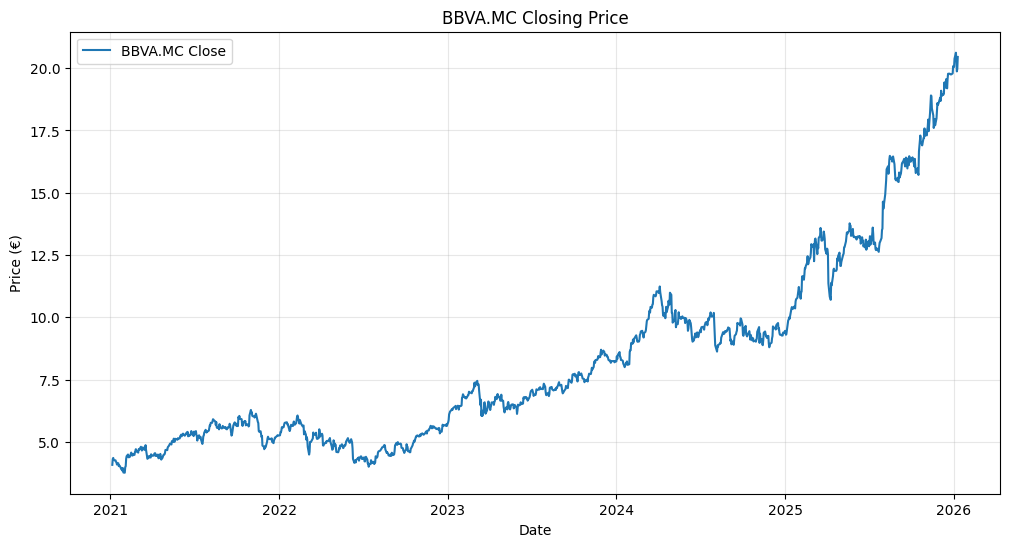

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="BBVA.MC Close", linewidth=1.5)

plt.title("BBVA.MC Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (€)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

We plot the original closing price series and visually observe a clear trend, indicating that the series is non-stationary.

In [38]:
test = adfuller(df["close"])
stationarity_interpretation = (
    "Stationary" if test[1] < 0.05 else "Non-Stationary"
)
print(f"ADF Statistic: {test[0]}")
print(f"p-value: {test[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic: 2.111496645035932
p-value: 0.9988014146577279
Interpretation: The series is Non-Stationary.


We apply the Augmented Dickey–Fuller (ADF) test to formally assess stationarity. This confirms the series is non-stationary.

In [39]:
prices = df["close"]
diffed_prices = prices.diff().dropna()
test = adfuller(diffed_prices)
stationarity_interpretation = (
    "Stationary" if test[1] < 0.05 else "Non-Stationary"
)
print(f"ADF Statistic: {test[0]}")
print(f"p-value: {test[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic: -12.118130235673402
p-value: 1.8519305965166622e-22
Interpretation: The series is Stationary.


Prices are used (vs. log returns) to see if we get better long term predictions. Differencing ensures stationarity which is confirmed with the ADF test.

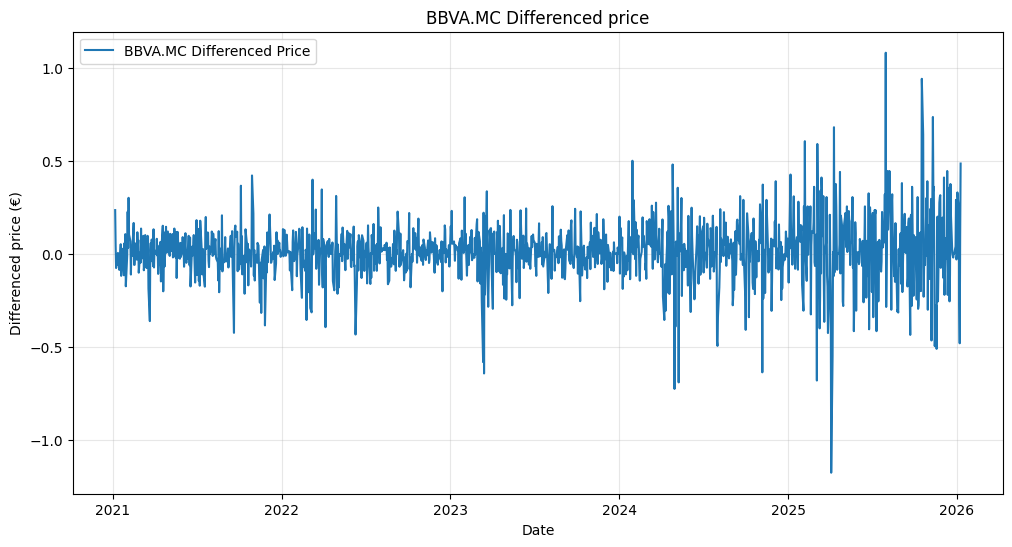

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(diffed_prices.index, diffed_prices, label="BBVA.MC Differenced Price", linewidth=1.5)

plt.title("BBVA.MC Differenced price")
plt.xlabel("Date")
plt.ylabel("Differenced price (€)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

We plot the differenced price series to visually inspect stationarity and assess the distribution of gains and losses over time.

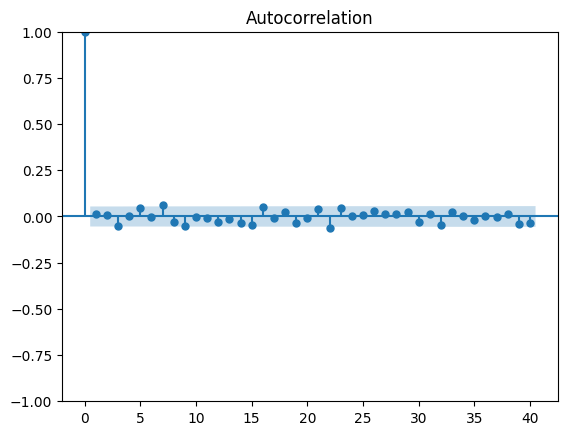

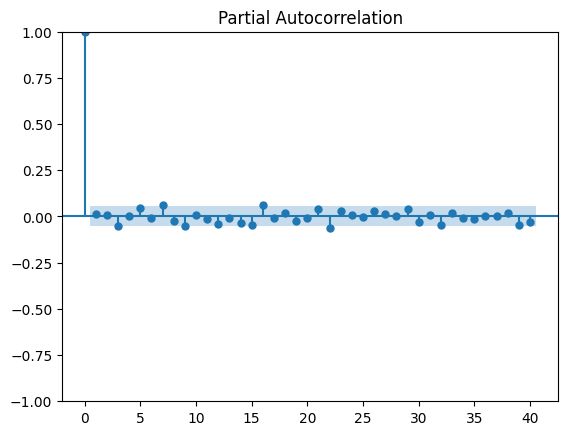

In [41]:
plot_acf(diffed_prices,lags=40);
plot_pacf(diffed_prices, lags=40);

We plot the autocorrelation (ACF) and partial autocorrelation (PACF) of the differenced price. Only the lag-0 correlation is significant, suggesting no meaningful temporal dependencies. Based on this, we select ARIMA(0,0,0), indicating that log returns behave like white noise.

In [42]:
p,d,q = 0,1,0
model = ARIMA(prices, order=(p,d,q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1309
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 505.252
Date:                Tue, 13 Jan 2026   AIC                          -1008.504
Time:                        18:36:18   BIC                          -1003.328
Sample:                    01-05-2021   HQIC                         -1006.562
                         - 01-09-2026                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0270      0.001     51.262      0.000       0.026       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              2069.68
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               4.18   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

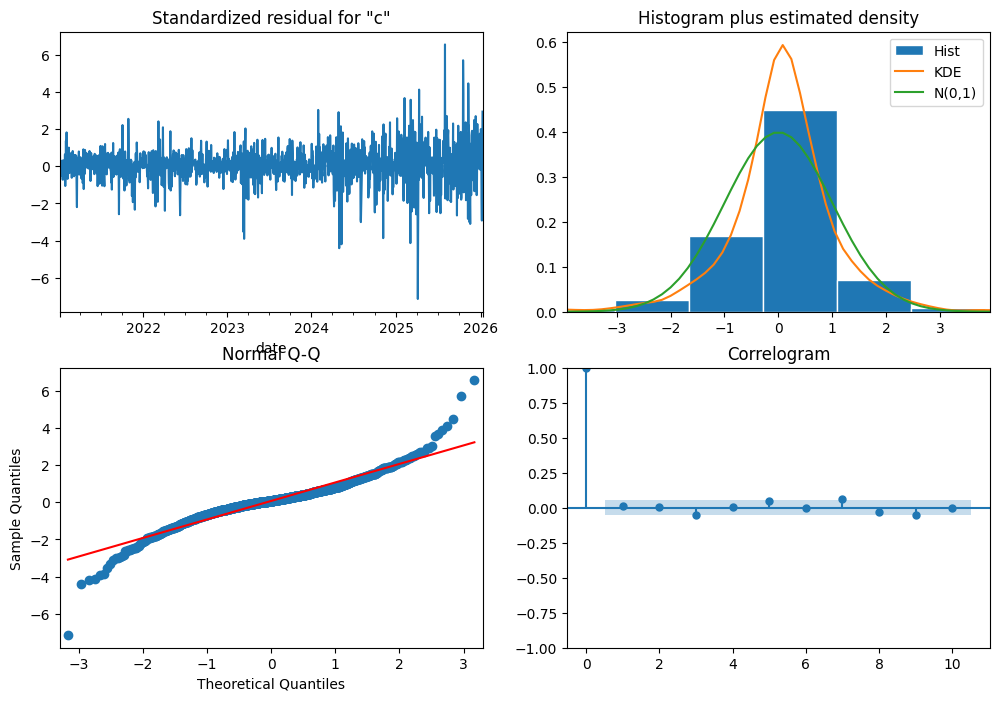

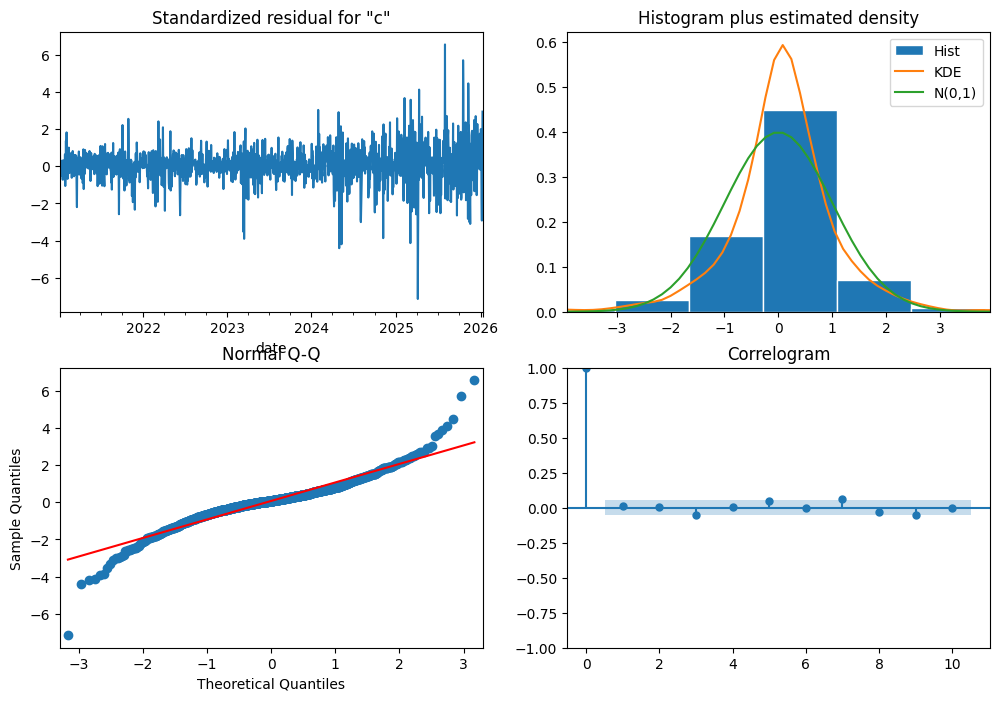

In [43]:
model_fit.plot_diagnostics(figsize=(12,8))

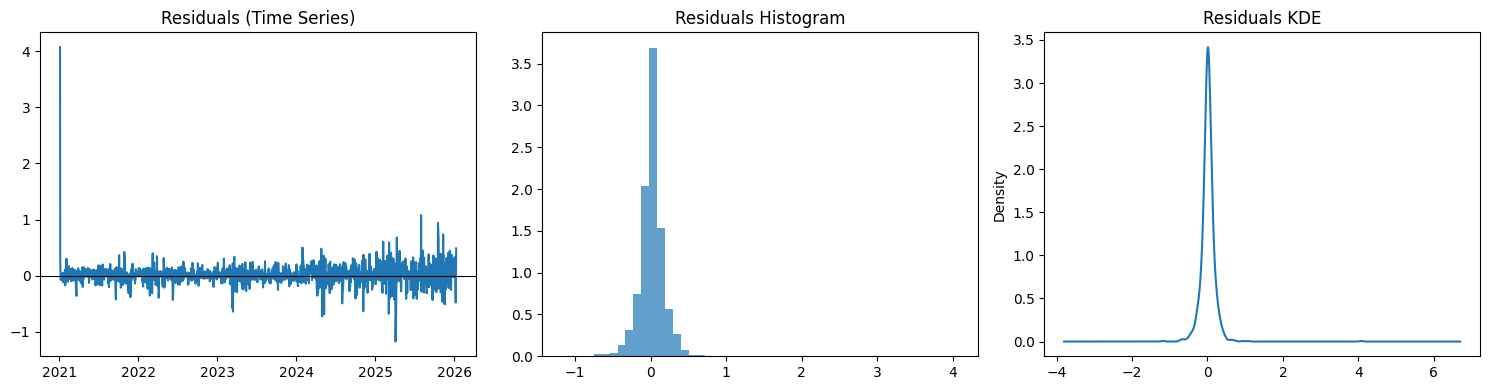

In [44]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(residuals)
axes[0].set_title("Residuals (Time Series)")
axes[0].axhline(0, color="black", linewidth=0.8)

axes[1].hist(residuals, bins=50, density=True, alpha=0.7)
axes[1].set_title("Residuals Histogram")

residuals.plot(kind="kde", ax=axes[2])
axes[2].set_title("Residuals KDE")

plt.tight_layout()
plt.show()


In [45]:
train_size = int(len(prices) * 0.8)
train = prices.iloc[:train_size]
test = prices.iloc[train_size:]

p,d,q = 0,1,0
p_model = ARIMA(train, order=(p,d,q))
p_model_fit = p_model.fit()
forecast = p_model_fit.forecast(steps=len(test))

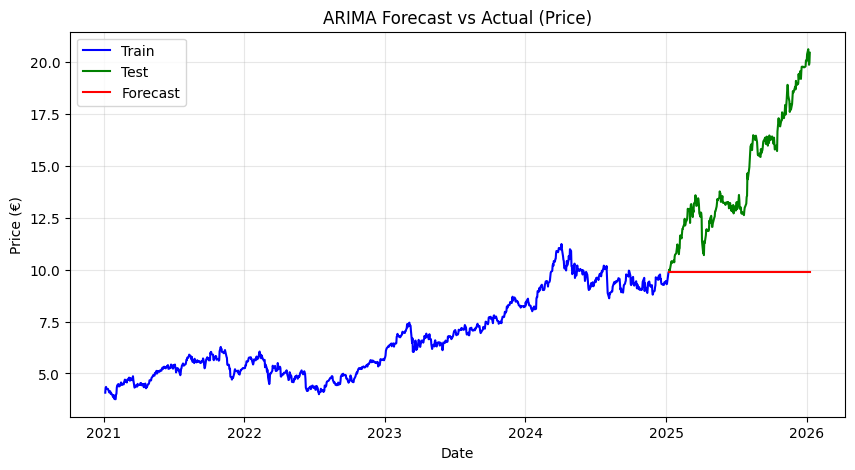

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')

plt.title('ARIMA Forecast vs Actual (Price)')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


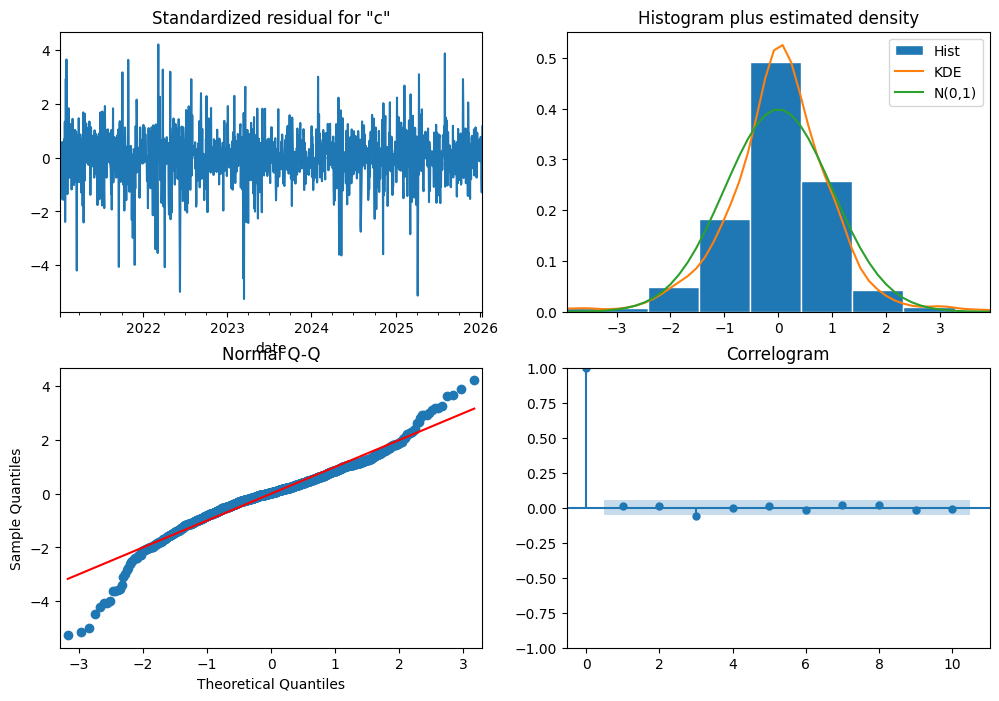

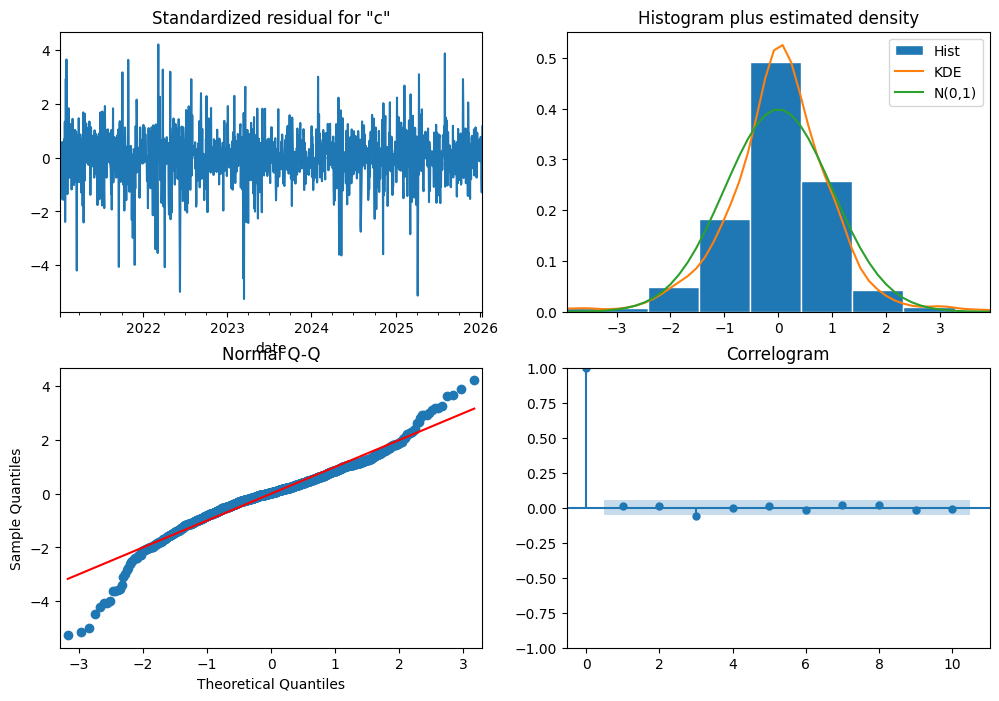

In [ ]:
model_fit.plot_diagnostics(figsize=(12,8))

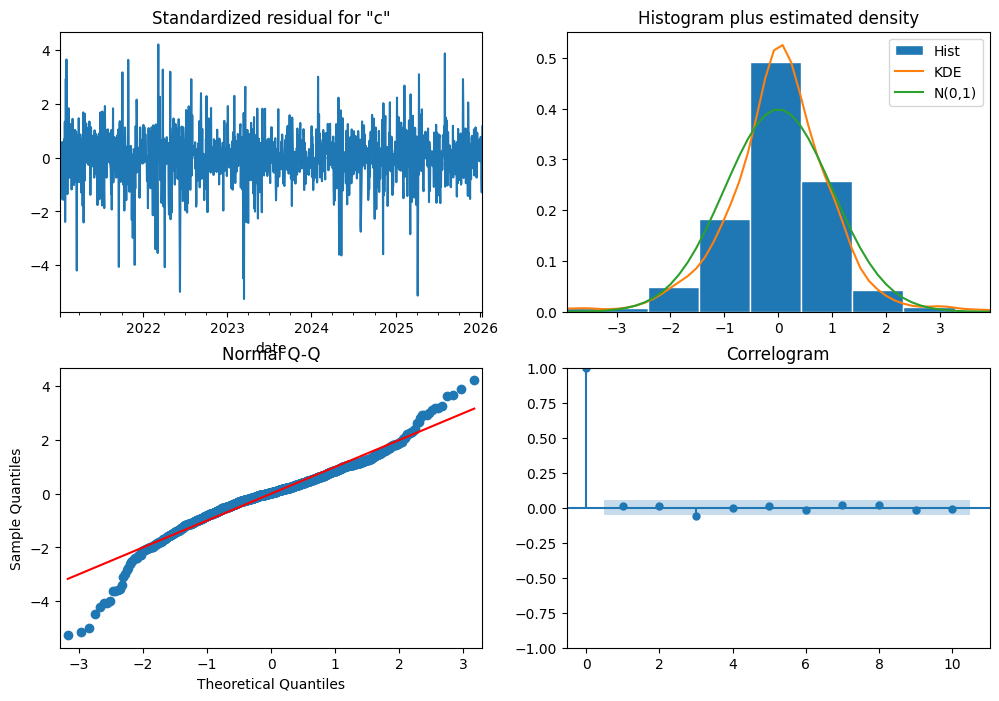

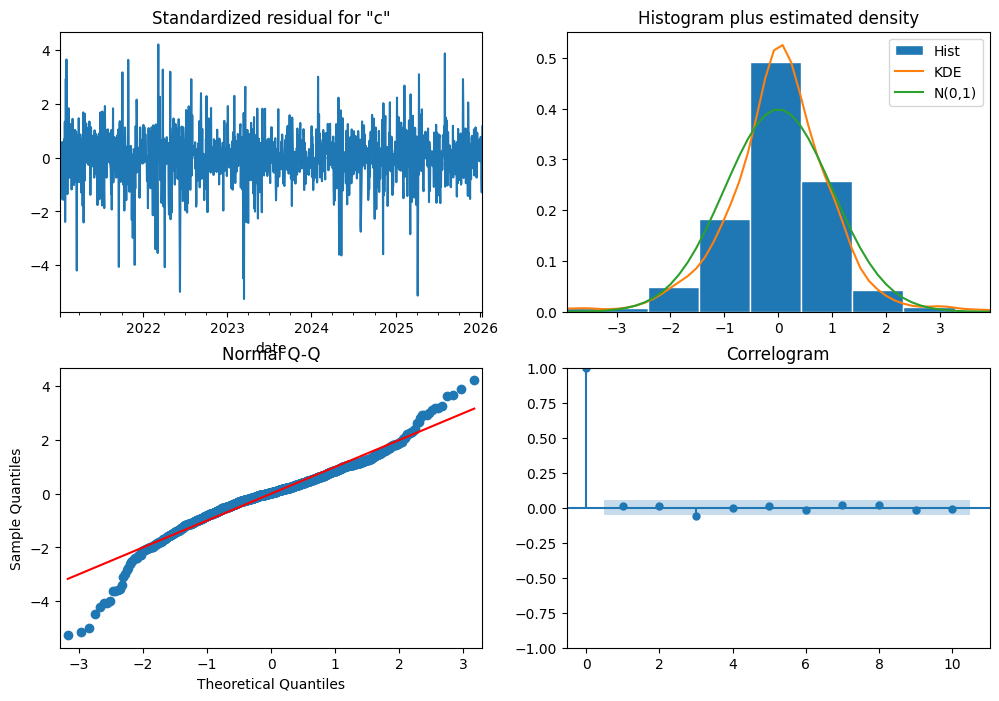

In [ ]:
model_fit.plot_diagnostics(figsize=(12,8))

We plot the ARIMA forecast for log returns. The model predicts the last the last known value, resulting in a flat line around it.

In [47]:
rmse_price = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (Price): {rmse_price:.4f} €")

RMSE (Price): 5.4780 €


We observe that there is am underlying linear trend, then proceed to adjust ARIMA model to make better predictions.


In [48]:
print(diffed_prices.mean())
model = ARIMA(prices, order=(0,1,0), trend="t")
result = model.fit()
print(result.summary())

0.012519878349537513
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1309
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 509.054
Date:                Tue, 13 Jan 2026   AIC                          -1014.108
Time:                        18:36:19   BIC                          -1003.756
Sample:                    01-05-2021   HQIC                         -1010.225
                         - 01-09-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0125      0.005      2.756      0.006       0.004       0.021
sigma2         0.0269      0.001     51.562      0.000       0.026       0.028
Ljung-Box (L1) (Q):            

In [49]:
train_size = int(len(prices) * 0.8)
train = prices.iloc[:train_size]
test = prices.iloc[train_size:]

p,d,q = 0,1,0
op_model = ARIMA(train, order=(p,d,q),trend="t")
op_model_fit = op_model.fit()
forecast = op_model_fit.forecast(steps=len(test))

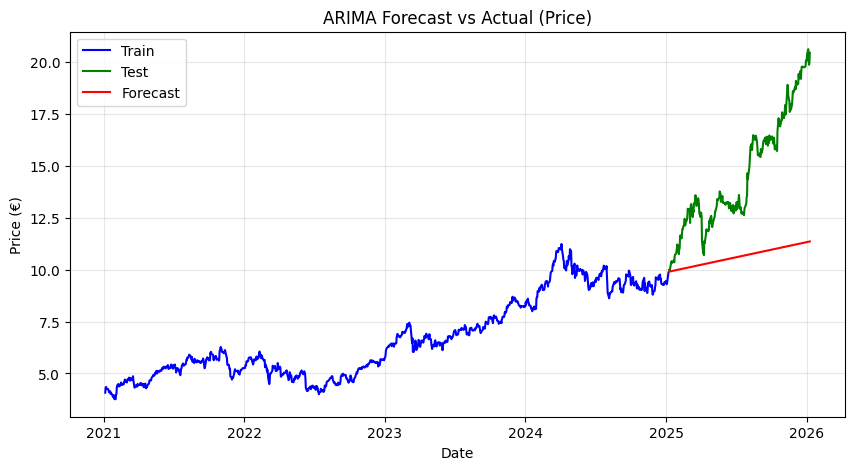

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')

plt.title('ARIMA Forecast vs Actual (Price)')
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()



In [51]:
rmse_price = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (Price): {rmse_price:.4f} €")


RMSE (Price): 4.6476 €
